# Module 6 - Logistic Regression

Logistic regression is a classification algorithm for supervised learning, and is a smoothed-out version of linear regression. However, instead of a linear trend line extending infinitely in both directions, the y-axis values (the target outcome) of logistic regression trend line (a **sigmoid** "S" shape) can only take on values between 0 and 1. These values represent the likelihood/probability of being in the target outcome value assigned to `1`.

![Logistic Regression](https://notebooks.azure.com/priesterkc/projects/images/raw/logistic_regression.png)
Source: [javaTpoint: Logistic Regression in Machine Learning](https://www.javatpoint.com/logistic-regression-in-machine-learning)

Logistic regression is typically used to classify a target with binary (two categories/options) outcomes, such as `Yes/No`, `True/False`, `spam/not spam`. The "most true" category will be numerically-encoded as `1` with the other category labeled `0`. The logistic regression function will also have a threshold value (probability cutoff) to predict a data point as one of the target categories, based on the x-axis value(s) (features) of the data point. On occasion, logistic regression can also be used for classifying when there are 3 or more target category outcomes.

## Titanic Survival

In this lesson, we will clean and prepare the dataset of Titanic passengers in order to build a logistic regression model. The model will predict a passenger's survival status (`0`= died, `1`= survived) based on certain characteristics.

In [12]:
# import libraries 
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# import functions directly from sci-kit learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [13]:
# read in dataset
filepath = "datasets/titanic.xls"

df = pd.read_excel(filepath)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Data Dictionary

The dataset contains the following features (characteristics) in the columns:

- `pclass`: passenger class (1 = 1st class, 2 = 2nd class, 3 = 3rd class) 
- `survived`: survival status (0 = No(died), 1 = Yes(survived))
- `name`: passenger's name
- `sex`: passenger's sex (male/female)
- `age`: passenger's age
- `sibsp`: number of siblings and/or spouses with passenger
- `parch`: number of parents and/or children with passenger
- `ticket`: ticket number
- `fare`: total fare for passenger and others in party (currency: British Pound)
- `cabin`: room cabin number(s) for passenger and their party
- `embarked`: port of embarkation (C = Chernbourg, Q = Queenstown, S = Southampton)
- `boat`: lifeboat name (combination of letters and/or numbers)
- `body`: body identification number
- `home.dest`: hometown or destination after disembark

### Exploratory Analysis

We will do a simple exploratory data analysis to understand what information is in the dataset, and identify any relationships or patterns in the data. The exploratory tasks we will do are:

- Compare the number of passengers by survival status
- Compare the ratio of men vs women that survived
- Compare the ratio of each passenger class that survived
- Compare the distribution of passengers based on age and survival status

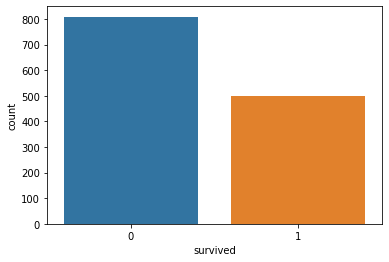

In [14]:
# number of passengers per survival status
sns.countplot(data=df, x='survived')

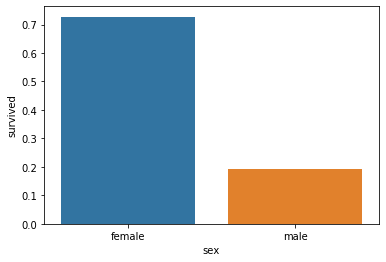

In [15]:
# ratio of passengers by gender that survived
sns.barplot(data=df, x='sex', y='survived', ci=None)

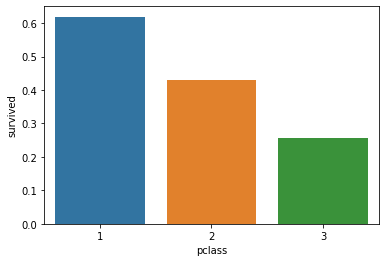

In [16]:
# ratio of passengers by class that survived
sns.barplot(data=df, x='pclass', y='survived', ci=None)

The `.kdeplot()` function creates a kernel density estimate plot, which shows the distribution curve of the data. The y-axis refers to a probability of a value occuring in a particular area of the density plot, but we will not use this concept for this course.

In [17]:
# select the age column with all rows of passengers that survived
survive_age = df['age'].loc[df['survived'] == 1]

# select the age column with all rows of passengers that died
died_age = df['age'].loc[df['survived'] == 0]

Text(0.5, 0, 'Age')

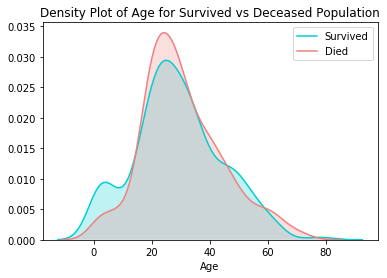

In [18]:
# density plot to compare distribution of age by survival status

# distribution of ages for passengers that survived
sns.kdeplot(survive_age, color="darkturquoise", shade=True)

# distribution of ages for passengers that died
sns.kdeplot(died_age, color="lightcoral", shade=True)

# add legend, chart title, and x-axis label
plt.legend (['Survived', 'Died'])
plt.title("Density Plot of Age for Survived vs Deceased Population")
plt.xlabel('Age')

### Clean and Prepare Data

After conducting exploratory analysis, we need to clean up the data and prepare it in a format for the predictive model. Columns relevant for our model will be cleaned and prepared, while colums and rows that are not significant for prediction will be removed. 

`age` and `embarked` are the only columns with missing values that will be used in the predictive model. We will fill in the missing information with a "guesstimate" and all the other columns with missing values will be removed from the dataframe.

In [19]:
# identify columns with missing values
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

#### Clean `age` column

In [20]:
# identify rows where age is missing
missing_age = df.loc[df['age'].isnull()]
missing_age.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
15,1,0,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S,NaN,NaN,"New York, NY"
37,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,NaN,0,0,111427,26.5500,NaN,S,9,NaN,"Los Angeles, CA"
40,1,0,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,NaN,NaN,"Philadelphia, PA"
46,1,0,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,S,NaN,NaN,NaN
59,1,1,"Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...",female,NaN,0,0,17770,27.7208,NaN,C,5,NaN,"New York, NY"


In [21]:
# save index positions of missing rows - we'll use this later
mals = list(missing_age.index)

From the earlier density plot, there were variations in the ratio of passengers for each survival status category, based on their age. Because there are many values missing in the `age` column, we will create an estimate value for `age` that's specific to a person's survival status, as well as other significant characteristics like sex and passenger class (a proxy for socio-economic status).

In [22]:
# average age grouped by survival status, sex, and passenger class
df.groupby(['survived', 'sex', 'pclass'])['age'].mean()

survived  sex     pclass
0         female  1         35.200000
                  2         34.090909
                  3         23.418750
          male    1         43.658163
                  2         33.092593
                  3         26.679598
1         female  1         37.109375
                  2         26.711051
                  3         20.814815
          male    1         36.168240
                  2         17.449274
                  3         22.436441
Name: age, dtype: float64

The `.transform()` function creates a single column that for every row of data, when the row matches the characteristics in a row of the `groupby`, it will take on that value. In this example, the `.transform()` produces a column where each row (passenger) has a mean average age, based on the passenger's survival status, sex, and passenger class.

Then we will take the transformed column and using the `.fillna()` function, take the value from the transformed row and only use it in the corresponding row in the dataframe if the passenger's age is missing.

In [23]:
# a column of mean age for each row (passenger)
df.groupby(['survived', 'sex', 'pclass'])['age'].transform('mean')

0       37.109375
1       36.168240
2       35.200000
3       43.658163
4       35.200000
          ...    
1304    23.418750
1305    23.418750
1306    26.679598
1307    26.679598
1308    26.679598
Name: age, Length: 1309, dtype: float64

In [24]:
# store transform column as a variable
tranform_age = df.groupby(['survived', 'sex', 'pclass'])['age'].transform('mean')

In [25]:
# fill missing values for age using values from transformed column
df['age'].fillna(tranform_age, inplace=True)

In [26]:
# verify filled missing values 
df.iloc[mals].head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
15,1,0,"Baumann, Mr. John D",male,43.658163,0,0,PC 17318,25.9250,NaN,S,NaN,NaN,"New York, NY"
37,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,36.168240,0,0,111427,26.5500,NaN,S,9,NaN,"Los Angeles, CA"
40,1,0,"Brewe, Dr. Arthur Jackson",male,43.658163,0,0,112379,39.6000,NaN,C,NaN,NaN,"Philadelphia, PA"
46,1,0,"Cairns, Mr. Alexander",male,43.658163,0,0,113798,31.0000,NaN,S,NaN,NaN,NaN
59,1,1,"Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...",female,37.109375,0,0,17770,27.7208,NaN,C,5,NaN,"New York, NY"


In [27]:
# verify there are no more missing age values
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

#### Clean `embarked` column

In [28]:
# check missing values for 'embarked'
embark = df.loc[df['embarked'].isnull()]
embark

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
168,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,6,NaN,NaN
284,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,6,NaN,"Cincinatti, OH"


In [29]:
#save index for missing values to verify later
embarkls = list(embark.index)

Because the values in the `embarked` column are string categories, we can't use statistical methods to impute the missing information. There are very few rows of missing data, so we can fill in those values with the most common port of embarkation.

In [30]:
# number of passengers for each embarkation port
df['embarked'].value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [31]:
# fill missing values with "S" for Southampton (most common port)
df['embarked'].fillna('S', inplace=True)

In [32]:
# check that values are filled
df.iloc[embarkls]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
168,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S,6,NaN,NaN
284,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S,6,NaN,"Cincinatti, OH"


In [33]:
# verify no missing values in 'embarked' column
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        0
boat          823
body         1188
home.dest     564
dtype: int64

#### Remove unnecessary columns

Now that the values are filled for columns that will be used in the predictive model, we can remove the columns that we do not need.

In [34]:
# remove columns that will not be used in the model
modeldf = df.drop(['name','ticket','fare', 'cabin', 'boat', 'body', 'home.dest'], axis=1)

In [35]:
# columns in the new dataframe
modeldf.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'embarked'], dtype='object')

### Feature Engineering

Some columns in the data are object types that have string values that cannot be used in the algorithm function. During the Module 4 lesson, we transformed ordinal qualitative values into a numerical representation that preserved their ranking. For nominal (non-ordered) data, there is no ranking, so we will use **one-hot encoding** to numerically represent the values.

One-hot encoding is a technique that takes discrete (categorical) data values from a column and creates a new column for each distinct category value. Within each column, the values `0` or `1` will be assigned, indicating a `True (1)` or `False (0)` value for that category. The one-hot encoded columns created are called **dummy variables**. 

The `pd.get_dummies()` function extracts the categories from a column, then makes them into dummy variables and assigns the boolean values. `pd.get_dummies` will automatically drop the column that was used as the source data.

In [36]:
# dummy variables for embarkation port
modeldf = pd.get_dummies(data=modeldf, columns=['embarked'])
modeldf.head()

,pclass,survived,sex,age,sibsp,parch,embarked_C,embarked_Q,embarked_S
0,1,1,female,29.0000,0,0,0,0,1
1,1,1,male,0.9167,1,2,0,0,1
2,1,0,female,2.0000,1,2,0,0,1
3,1,0,male,30.0000,1,2,0,0,1
4,1,0,female,25.0000,1,2,0,0,1


#### Categorical sex values as boolean

Boolean values are very common to use to represent binary (two options) categorical data. For the model, we will reassign the string values for sex as boolean values.

In [37]:
# reassign 'female'= 0, 'male'= 1
modeldf['sex'] = modeldf['sex'].map({'female':0, 'male':1})
modeldf.head()

,pclass,survived,sex,age,sibsp,parch,embarked_C,embarked_Q,embarked_S
0,1,1,0,29.0000,0,0,0,0,1
1,1,1,1,0.9167,1,2,0,0,1
2,1,0,0,2.0000,1,2,0,0,1
3,1,0,1,30.0000,1,2,0,0,1
4,1,0,0,25.0000,1,2,0,0,1


#### Combine family member total

In the dataset, there are separate columns for immediate family members that are in the same generation as the passenger (`sibsp` - sibling/spouse) or different generations (`parch` - parent/child). During the incident of the Titanic sinking, if a passenger were traveling with any family members then we should account for them all in a single column. Furthermore, we can also hypothesize that the more family members a passenger is traveling with, the more difficult it would have been to quickly move everybody to safety. For this reason, more family members might be linked to decreased survival likelihood, which is why we will create a new `family_num` column in the dataframe.

In [ ]:
# create new column based on number of family members
modeldf['family_num'] = modeldf['sibsp'] + modeldf['parch']

# drop sibsp and parch columns
modeldf.drop(['sibsp', 'parch'], axis=1, inplace=True)
modeldf.head()

### Predictive Modeling

The data is "done" being cleaned and prepared, so now we can build, or **fit**, our logistic regression model. There are a few final tasks that need to be done before the data is given to the model:

- Separate the attributes (features used to predict) from the target (outcome to predict)
- Shuffle the order of the rows in the dataset, then separate into a dataset for training (for the model to learn from) and testing (to see how well it predicts with new data)

When the model finishes "learning" with the training data, we will evaluate its performance.

#### Separate attributes and target

The target is the column of data we are teaching the model to predict. In math, this information is typically represented as the variable `y`, so we keep the same conventions. Attributes (characteristics) that calculate/predict `y` are stored into a variable called `X`. Although `y` is a single column, `X` is a dataframe of all the attribute columns.

In [ ]:
# 'survived' is target variable
y = modeldf['survived']

In [ ]:
# attributes are all the columns EXCEPT 'survived'
X = modeldf.drop(['survived'], axis=1)

#### Separate training and test data

Scikit-learn's `train_test_split()` function takes the attribute columns (`X` variable) and target column (`y` variable), then shuffles the rows using the `random_state=` argument, which will trigger a randomizing sequence (see the [`random_state` documentation](https://scikit-learn.org/stable/glossary.html#term-random-state) for more information). By default, `test_size=` will separate 25% of the dataset as the test set, leaving the other 75% for the training set. However, you can adjust the value of the ratio split.

`train_test_split()` then generates four outputs in this order - a dataframe of the attributes for the training set (`X_train`), a dataframe of the attributes for the test set (`X_test`), a column of the target for the training set (`y_train`), and a column of the target for the test set (`y_test`).

In [ ]:
# separate 80% for training data, 20% for test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train the model

The `LogisticRegression()` function will take the `X_train` and `y_train` dataset, and calculate the attributes' parameters (weights) and sigmoid line shape that best fits the data.

In [ ]:
# assign logistic regression function to variable
model = LogisticRegression()

In [ ]:
# give training data to learn
model.fit(X_train, y_train)

In [ ]:
# overall ratio of correct predictions for training data
model.score(X_train, y_train)

#### Evaluate the model on test data

To assess how well the model will perform on new data, we will use the test set to:

- Display the ratio of overall correct predictions
- Compare the number of correct and incorrect predictions for each target category
- Compare the ratio of correct predictions for all actual target values and all predicted values for a category

In [ ]:
# overall ratio of correct predictions for test data
model.score(X_test, y_test)

In [ ]:
# generate predictions
y_pred = model.predict(X_test)

In [ ]:
# compare how many items in each category model predicted correctly vs incorrectly

cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted: Died', 'Predicted: Survived'],
    index=['Actual: Died', 'Actual: Survived']
)

cm

In [ ]:
# compare ratio of correct predictions vs all predicted values for each category (precision)
# compare ratio of correct predictions vs all actual values for each category (recall)

print(classification_report(y_test, y_pred))

Sources:

https://nbviewer.jupyter.org/github/BigDataGal/Data-Mania-Demos/blob/master/Logistic%20Regression%20Demo.ipynb

https://mashimo.wordpress.com/2018/03/31/logistic-regression-using-sklearn/

https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python/notebook

https://datascienceplus.com/would-you-survive-the-titanic-getting-started-in-python/

https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8